In [14]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [15]:
model = YOLO(model="checkpoint/nx_yolo.pt")

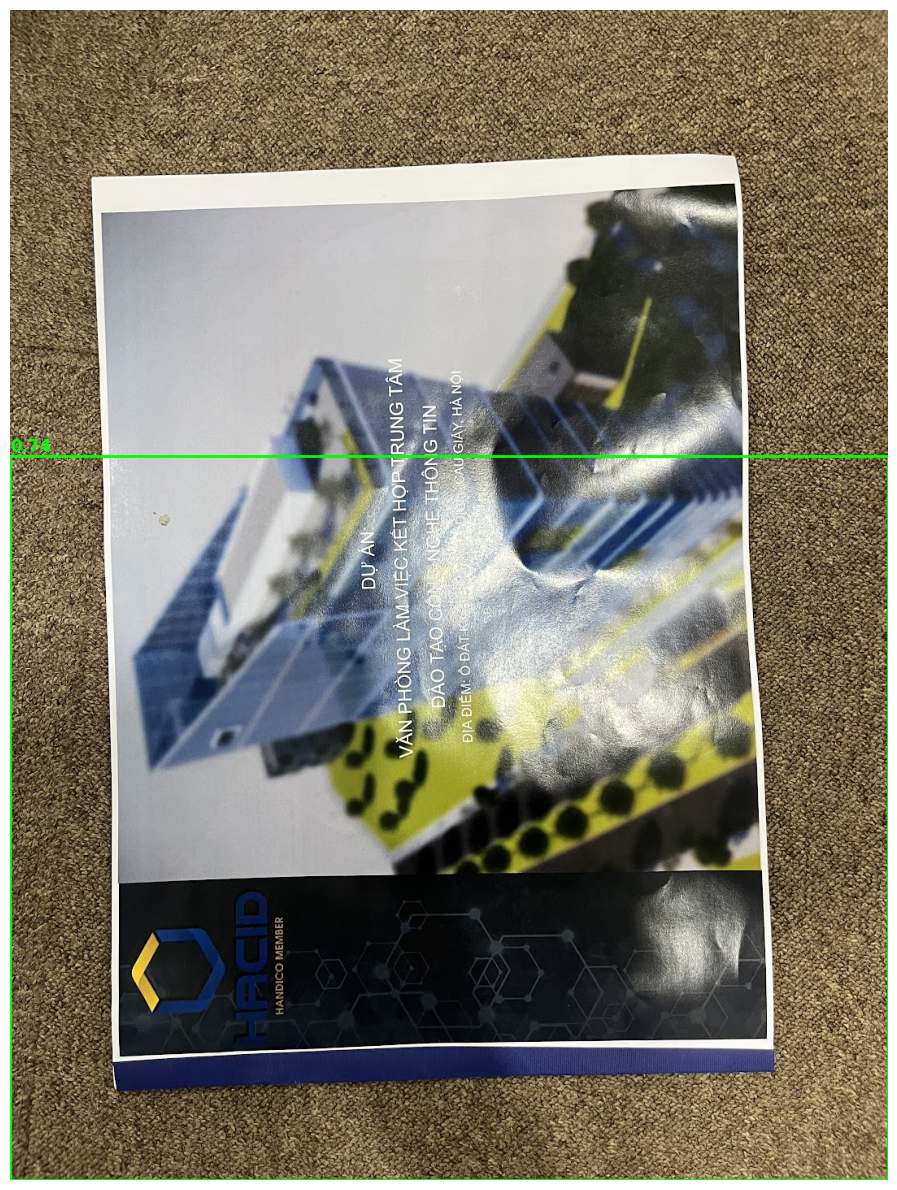

In [16]:
# Read the image
img_path = "/data_hdd_16t/duydang/nxscan/data/Image_20250709_155112_899.png"
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

res = model.predict(str(img_path), verbose=False)[0]
# Get boxes and confidence
boxes = res.boxes.xyxy.cpu().numpy()  # (x1, y1, x2, y2)
confs = res.boxes.conf.cpu().numpy()

# Plot
fig, ax = plt.subplots(1, figsize=(12, 12))
ax.imshow(img_rgb)
for (x1, y1, x2, y2), conf in zip(boxes, confs):
    width = x2 - x1
    height = y2 - y1
    rect = patches.Rectangle((x1, y1), width, height,
                             linewidth=2, edgecolor='lime', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, f"{conf:.2f}", color='lime', fontsize=12, weight='bold')

plt.axis('off')
plt.tight_layout()
plt.show()
